# Measuring the policy impact of an organization using policy document citations

This notebook shows how to use the [Dimensions Analytics API](https://www.dimensions.ai/dimensions-apis/) to analyze the policy impact of an organization. 

We will do this by counting the indirect links via publications, **hence it permits to gain some insight into the *indirect* policy impact of a research organization**. The goal therefore is to extract and inspect policy documents that *cite* publications from the research organization in question.   

Since the various content types included in the Dimensions database are [deeply interlinked](https://docs.dimensions.ai/dsl/data-sources.html), the Dimensions APIs allow to perform this analysis via a few simple steps: 

* We start from a [GRID](https://grid.ac/) identifier (representing a research organization in Dimensions).
* We use the [publications API](https://docs.dimensions.ai/dsl/datasource-publications.html) to extract all publications where at least one author is/was affiliated to the GRID organization, for a selected time period.
* We then use the [policy documents API](https://docs.dimensions.ai/dsl/datasource-policy_documents.html) to discover policy documents that include citations to any of those publications.
* Finally, we analyse the policy documents data to highlight trends.


In [2]:
import datetime
print("==\nCHANGELOG\nThis notebook was last run on %s\n==" % datetime.date.today().strftime('%b %d, %Y'))

==
CHANGELOG
This notebook was last run on Apr 20, 2023
==


## Prerequisites

This notebook assumes you have installed the [Dimcli](https://pypi.org/project/dimcli/) library and have followed the steps in the ['Getting Started' tutorial](https://api-lab.dimensions.ai/cookbooks/1-getting-started/1-Using-the-Dimcli-library-to-query-the-API.html).

In [3]:
!pip install dimcli plotly tqdm -U --quiet 

import dimcli
from dimcli.utils import *

import os, sys, time, json
from tqdm.notebook import tqdm as progressbar

import pandas as pd

import plotly.express as px
from plotly.offline import plot
if not 'google.colab' in sys.modules:
  # make js dependecies local / needed by html exports
  from plotly.offline import init_notebook_mode
  init_notebook_mode(connected=True)

print("==\nLogging in..")
# https://digital-science.github.io/dimcli/getting-started.html#authentication
ENDPOINT = "https://app.dimensions.ai"
if 'google.colab' in sys.modules:
  import getpass
  KEY = getpass.getpass(prompt='API Key: ')  
  dimcli.login(key=KEY, endpoint=ENDPOINT)
else:
  KEY = ""
  dimcli.login(key=KEY, endpoint=ENDPOINT)
dsl = dimcli.Dsl()

Searching config file credentials for 'https://app.dimensions.ai' endpoint..


==
Logging in..
Dimcli - Dimensions API Client (v1.0.2)
Connected to: <https://app.dimensions.ai/api/dsl> - DSL v2.6
Method: dsl.ini file


## 1. Choosing a research organization's GRID identifier

For the purpose of this exercise, we are going to use GRID ID [grid.1005.4](https://www.grid.ac/institutes/grid.1005.4) (UNSW Sydney, Australia). Feel free  to change the parameters below as you want, for example by [choosing another organization's GRID ID](https://grid.ac/institutes), or doing a fuzzy search by organization name, below. (The name you enter will appear in the graphs produced below.)

In [4]:
ORG = "UNSW Sydney" #@param {type:"string"}
dsl.query(f"""search organizations where name ~ "{ORG}" return organizations""").as_dataframe()

Returned Organizations: 1 (total = 1)
Time: 6.71s


,id,name,acronym,city_name,country_name,latitude,linkout,longitude,state_name,types
0,grid.1005.4,UNSW Sydney,UNSW,Sydney,Australia,-33.917732,[https://www.unsw.edu.au/],151.23096,New South Wales,[Education]


In [5]:

GRIDID = "grid.1005.4" #@param {type:"string"}

#@markdown The start/end year of publications used to extract policy documents
YEAR_START = 2017 #@param {type: "slider", min: 1950, max: 2022}
YEAR_END = 2019 #@param {type: "slider", min: 1950, max: 2022}

if YEAR_END < YEAR_START:
  YEAR_END = YEAR_START

from IPython.display import display, HTML
display(HTML(f'---<br /><a href="{dimensions_url(GRIDID)}">View {GRIDID} in Dimensions &#x29c9;</a>'.format(dimensions_url(GRIDID))))

#@markdown ---


## 2. Extracting publications data

By looking at the [Dimensions API data model](https://docs.dimensions.ai/dsl/data-sources.html), we can see that policy documents and publications are connected by a property called `publication_ids`, which goes *from* policy documents *to* publications. This property represents the publication citations found in policy documents.

Hence, we need to...
1. ...query for all publications with authors affiliated to our GRID ID;
2. ...query for policy documents citing these publications.

In [5]:
# Get full list of publications linked to this organization for the selected time frame

q = f"""search publications 
        where research_orgs.id="{GRIDID}" 
        and year in [{YEAR_START}:{YEAR_END}]
        return publications[id+doi+title+type+journal+year+research_orgs+researchers+category_for+times_cited]"""
print("===\n", q, "\n===")
pubs_json = dsl.query_iterative(q, limit=1000)
pubs = pubs_json.as_dataframe()

Starting iteration with limit=1000 skip=0 ...


===
 search publications 
        where research_orgs.id="grid.1005.4" 
        and year in [2017:2019]
        return publications[id+doi+title+type+journal+year+research_orgs+researchers+category_for+times_cited] 
===


0-1000 / 29175 (6.10s)
1000-2000 / 29175 (8.72s)
2000-3000 / 29175 (7.96s)
3000-4000 / 29175 (5.99s)
4000-5000 / 29175 (5.46s)
5000-6000 / 29175 (5.45s)
6000-7000 / 29175 (5.11s)
7000-8000 / 29175 (5.59s)
8000-9000 / 29175 (5.73s)
9000-10000 / 29175 (6.26s)
10000-11000 / 29175 (5.76s)
11000-12000 / 29175 (5.31s)
12000-13000 / 29175 (7.22s)
13000-14000 / 29175 (5.68s)
14000-15000 / 29175 (5.38s)
15000-16000 / 29175 (5.15s)
16000-17000 / 29175 (4.97s)
17000-18000 / 29175 (5.62s)
18000-19000 / 29175 (5.40s)
19000-20000 / 29175 (6.45s)
20000-21000 / 29175 (4.25s)
21000-22000 / 29175 (4.82s)
22000-23000 / 29175 (6.50s)
23000-24000 / 29175 (5.86s)
24000-25000 / 29175 (6.04s)
25000-26000 / 29175 (5.70s)
26000-27000 / 29175 (5.46s)
27000-28000 / 29175 (6.11s)
28000-29000 / 29175 (5.46s)
29000-29175 / 29175 (2.61s)
===
Records extracted: 29175


## 3. Extracting policy documents linked to publications

In this section, we extract all policy documents linked to the publications dataset previously created. The steps are the following:

* we loop over the publication IDs and create policy document queries, via the referencing `publication_ids` field of policy documents;
* we collate all policy documents data, remove duplicates from policy documents and save the results;
* finally, we count policy documents per publication and enrich the original publications dataset with these numbers.

In [6]:
#
# the main policy documents query
#
q = """search policy_documents 
        where publication_ids in {} 
      return policy_documents[basics+publication_ids+category_for]"""

BATCHSIZE = 250
VERBOSE = False # set to True to see policy documents extraction logs


#
# loop through all pub IDs in chunks and query policy documents 
#
print("===\nExtracting policy documents data ...")
policy_documents_json = []
pubsids = pubs['id']

for chunk in progressbar(list(chunks_of(list(pubsids), BATCHSIZE))):
    data = dsl.query_iterative(q.format(json.dumps(chunk)), verbose=VERBOSE)
    policy_documents_json += data.policy_documents
    time.sleep(1)
    

policy_documents = pd.DataFrame().from_dict(policy_documents_json)
policy_documents.drop_duplicates(subset='id', inplace=True)
print("Policy documents found: ", len(policy_documents)) 

===
Extracting policy documents data ...


  0%|          | 0/117 [00:00<?, ?it/s]

Policy documents found:  1073


### Enriching publications with policy document citation metrics

Each policy document record contains all the `publication_ids` it cites, so we can take this metric to enrich the original publications dataset we created above. 

In [7]:
def count_policy_documents_per_pub(pubid):
  global policy_documents
  return len(policy_documents[policy_documents['publication_ids'].str.contains(pubid)])

# turn lists into strings to ensure compatibility with CSV loaded data
# see also: https://stackoverflow.com/questions/23111990/pandas-dataframe-stored-list-as-string-how-to-convert-back-to-list
policy_documents['publication_ids'] = policy_documents['publication_ids'].apply(lambda x: ','.join(map(str, x))) 

progressbar.pandas()
pubs['policy_documents'] = pubs['id'].progress_apply(lambda x: count_policy_documents_per_pub(x))

  0%|          | 0/29175 [00:00<?, ?it/s]

Now the `policy_documents` column gives us the top publications by number of citing policy documents.

In [8]:
pubs.sort_values("policy_documents", ascending=False).head(5)

,id,title,category_for,doi,research_orgs,researchers,times_cited,type,year,journal.id,journal.title,policy_documents
26407,pub.1084771026,Climate change impacts in the Middle East and ...,"[{'id': '80154', 'name': '4406 Human Geography...",10.1007/s10113-017-1144-2,"[{'acronym': 'ODI', 'city_name': 'London', 'co...","[{'first_name': 'Katharina', 'id': 'ur.0132307...",111,article,2017,jour.1051354,Regional Environmental Change,20
20622,pub.1099661937,Estimates of global seasonal influenza-associa...,"[{'id': '80003', 'name': '32 Biomedical and Cl...",10.1016/s0140-6736(17)33293-2,"[{'acronym': 'CDC', 'city_name': 'Nairobi', 'c...","[{'first_name': 'Angela Danielle', 'id': 'ur.0...",1639,article,2017,jour.1077219,The Lancet,16
28292,pub.1003731534,Surviving Sepsis Campaign: International Guide...,"[{'id': '80003', 'name': '32 Biomedical and Cl...",10.1007/s00134-017-4683-6,"[{'city_name': 'Houston', 'country_name': 'Uni...","[{'first_name': 'Andrew', 'id': 'ur.0104066565...",4572,article,2017,jour.1313639,Intensive Care Medicine,14
26159,pub.1085284420,Mortality risk during and after opioid substit...,"[{'id': '80003', 'name': '32 Biomedical and Cl...",10.1136/bmj.j1550,"[{'acronym': 'ENS', 'city_name': 'Madrid', 'co...","[{'first_name': 'Luis', 'id': 'ur.01346441735....",1045,article,2017,jour.1017377,The BMJ,14
17519,pub.1103160874,Investing in non-communicable disease preventi...,"[{'id': '80141', 'name': '4206 Public Health'}...",10.1016/s0140-6736(18)30667-6,"[{'acronym': 'WHO', 'city_name': 'Geneva', 'co...","[{'first_name': 'Rachel A', 'id': 'ur.01013221...",214,article,2018,jour.1077219,The Lancet,13


In [9]:
pubs_cited = pubs.query("policy_documents > 0 ").sort_values('policy_documents', ascending=False).copy()
pubs_cited.head(5)

,id,title,category_for,doi,research_orgs,researchers,times_cited,type,year,journal.id,journal.title,policy_documents
26407,pub.1084771026,Climate change impacts in the Middle East and ...,"[{'id': '80154', 'name': '4406 Human Geography...",10.1007/s10113-017-1144-2,"[{'acronym': 'ODI', 'city_name': 'London', 'co...","[{'first_name': 'Katharina', 'id': 'ur.0132307...",111,article,2017,jour.1051354,Regional Environmental Change,20
20622,pub.1099661937,Estimates of global seasonal influenza-associa...,"[{'id': '80003', 'name': '32 Biomedical and Cl...",10.1016/s0140-6736(17)33293-2,"[{'acronym': 'CDC', 'city_name': 'Nairobi', 'c...","[{'first_name': 'Angela Danielle', 'id': 'ur.0...",1639,article,2017,jour.1077219,The Lancet,16
26159,pub.1085284420,Mortality risk during and after opioid substit...,"[{'id': '80003', 'name': '32 Biomedical and Cl...",10.1136/bmj.j1550,"[{'acronym': 'ENS', 'city_name': 'Madrid', 'co...","[{'first_name': 'Luis', 'id': 'ur.01346441735....",1045,article,2017,jour.1017377,The BMJ,14
28292,pub.1003731534,Surviving Sepsis Campaign: International Guide...,"[{'id': '80003', 'name': '32 Biomedical and Cl...",10.1007/s00134-017-4683-6,"[{'city_name': 'Houston', 'country_name': 'Uni...","[{'first_name': 'Andrew', 'id': 'ur.0104066565...",4572,article,2017,jour.1313639,Intensive Care Medicine,14
17519,pub.1103160874,Investing in non-communicable disease preventi...,"[{'id': '80141', 'name': '4206 Public Health'}...",10.1016/s0140-6736(18)30667-6,"[{'acronym': 'WHO', 'city_name': 'Geneva', 'co...","[{'first_name': 'Rachel A', 'id': 'ur.01013221...",214,article,2018,jour.1077219,The Lancet,13


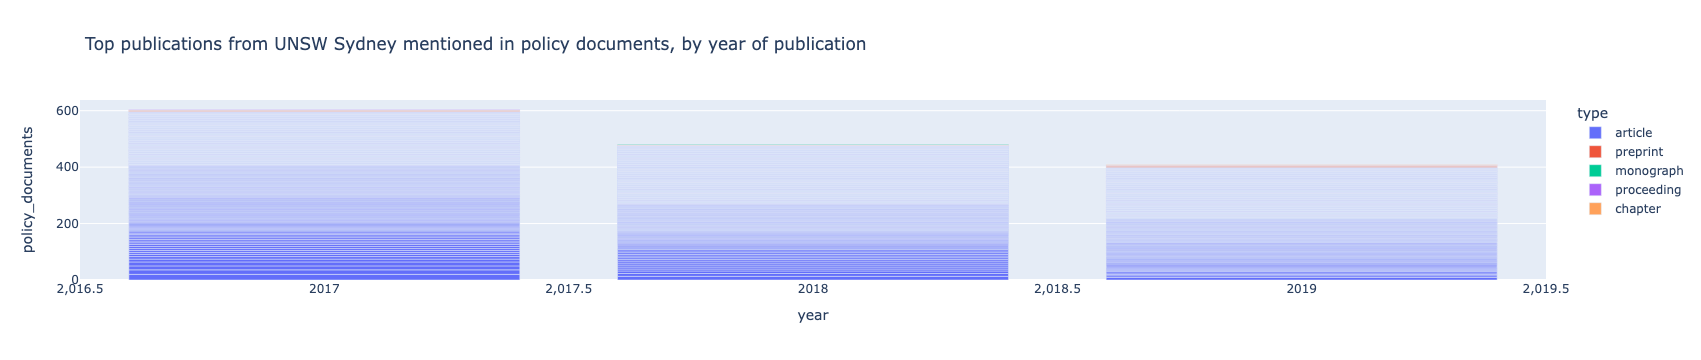

In [10]:
px.bar(pubs_cited[:1000], 
       color="type",
       x="year", y="policy_documents", 
       hover_name="title",  hover_data=["journal.title"],
       title=f"Top publications from {ORG} mentioned in policy documents, by year of publication")

## 4. Policy documents data analysis

Now that we have extracted all the data we need, let's start exploring it by building a few visualizations. 

###  How many policy documents per year? 

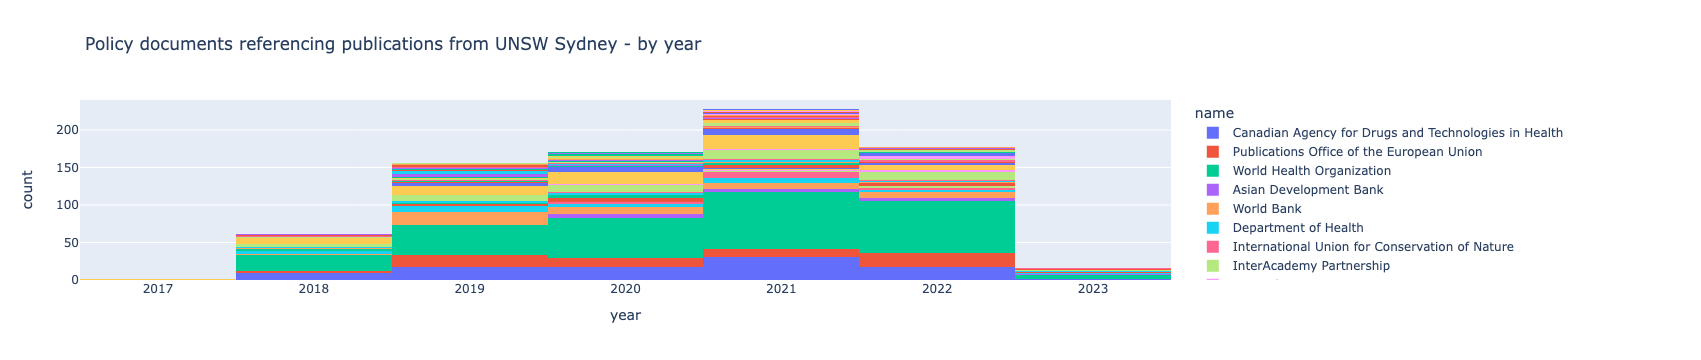

In [11]:
# unpack publisher_org dictionary 
temp = policy_documents.assign(**json_normalize(policy_documents['publisher_org'], errors="ignore"))

px.histogram(temp.dropna(subset=['name']), x="year", 
             color="name", 
             barmode="stack", 
             title=f"Policy documents referencing publications from {ORG} - by year")

### Who is publishing the policy documents?

This can be done by looking at the field `publisher_org` of policy documents. Since the field contains nested information, we first need to extract it into its own table (similarly to what we've done above with publications categories). 

In [12]:
temp = policy_documents.assign(**json_normalize(policy_documents['publisher_org'], errors="ignore"))

top_publisher_org = temp.groupby(['name', 'country_name'],  
                                          as_index=False).count().sort_values(by="id", ascending=False)
# preview the data: ps the policy_documents_id column is the COUNT of policy documents
top_publisher_org[['name', 'country_name', 'id']].head()

,name,country_name,id
61,World Health Organization,Switzerland,265
5,Canadian Agency for Drugs and Technologies in ...,Canada,94
42,Publications Office of the European Union,Luxembourg,60
31,National Institute for Health and Care Excellence,United Kingdom,59
11,Food and Agriculture Organization of the Unite...,Italy,46


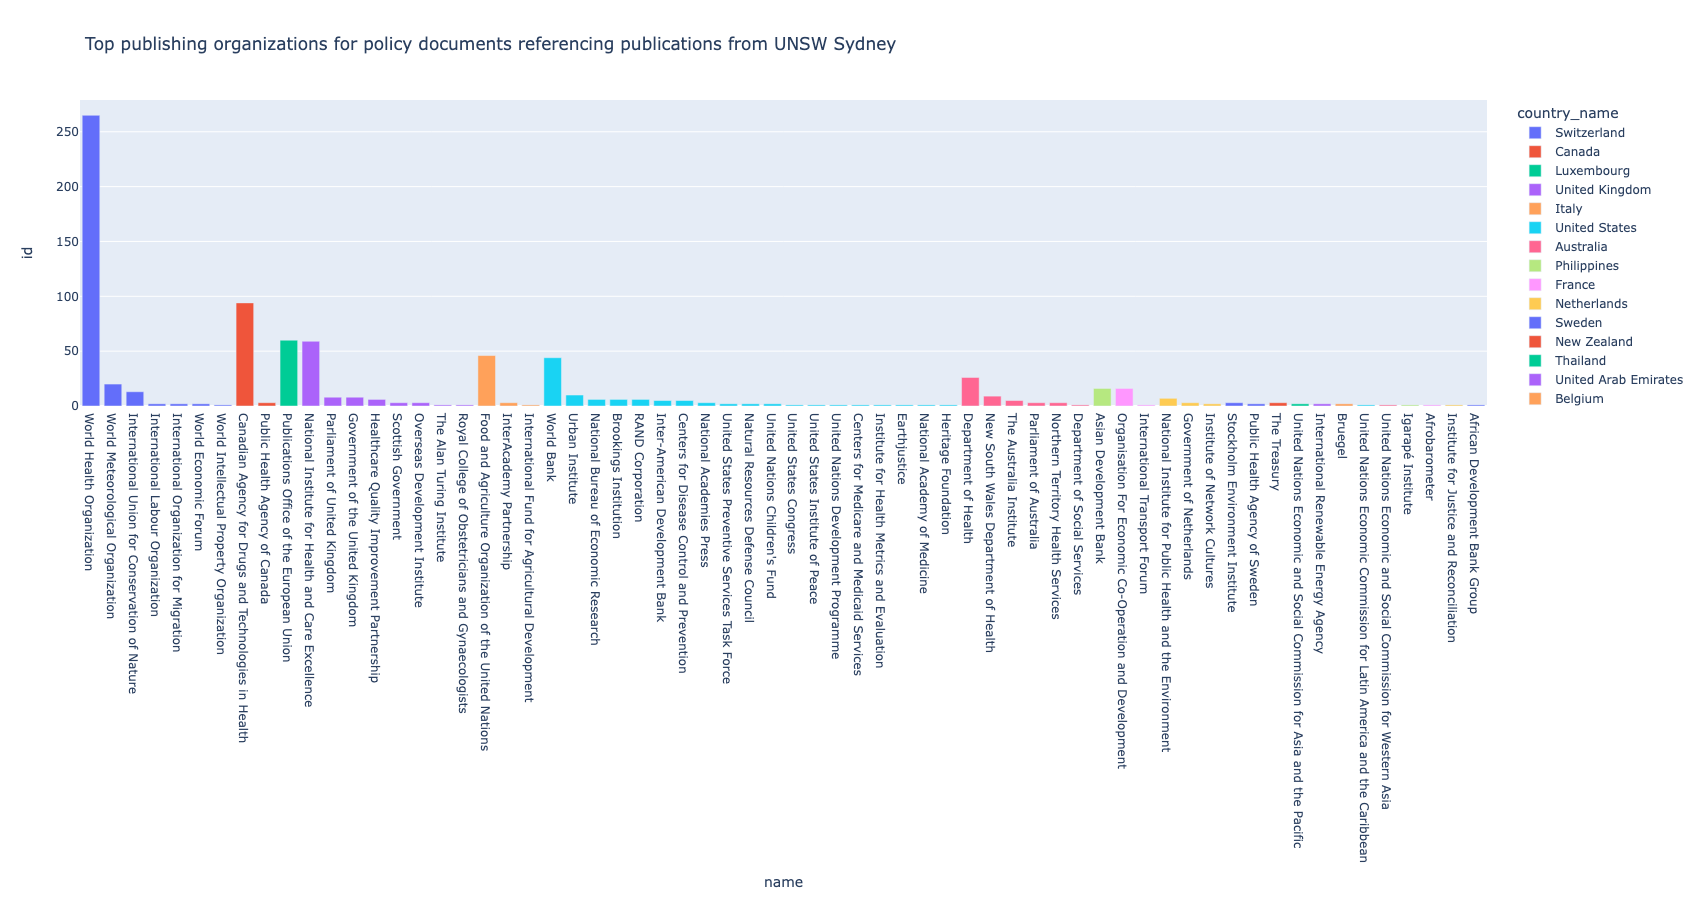

In [13]:
px.bar(top_publisher_org, 
       x="name", y="id", 
       hover_name="name", color="country_name",
       height=900,
       title=f"Top publishing organizations for policy documents referencing publications from {ORG}")

### What are the main subject areas of the publications most frequently referenced in policy documents?

We can use the Fields of Research categories information in publications to obtain a breakdown of the publications by subject area. 

This can be achieved by 'exploding' the `category_for` data into a separate table, since there can be more than one category per publication. The new categories table also retains some basic info about the publications it relates to, e.g. *journal*, *title*, *publication id*, etc., to make it easier to analyse the data. 

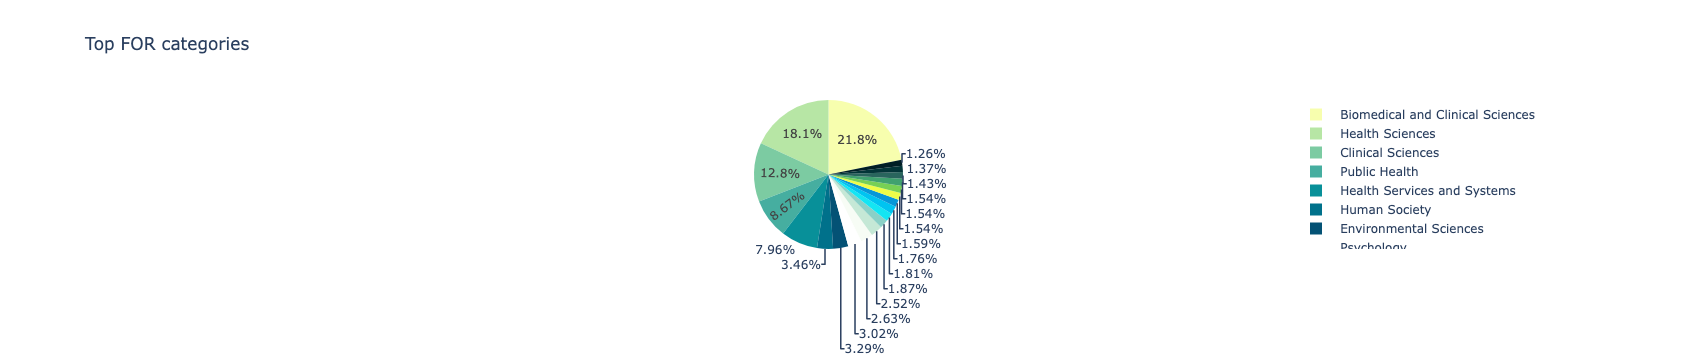

In [14]:
pubs_categories = pubs_cited.explode('category_for')
pubs_categories.dropna(subset=["category_for"], inplace=True)

def for_nice_name(for_dict):
    "transforms a category JSON into a nice looking title"
    if type(for_dict) == dict:
        name = for_dict['name']
        return ''.join([i for i in name if not i.isdigit()])
    else:
        return ""

# new col for nice name
pubs_categories["category_for_name"] = pubs_categories['category_for'].apply(lambda x: for_nice_name(x))
# new col for tot-pubs count
pubs_categories['count_pubs'] = pubs_categories.groupby("category_for_name")['id'].transform('count')

# Visualize the top categories using a pie chart...
categories = pubs_categories.drop_duplicates(subset="category_for_name").sort_values("count_pubs", ascending=False)[['category_for_name', 'count_pubs']]

px.pie(categories[:20], 
       names="category_for_name", # the dimension for the slices
       values="count_pubs",  # the metric
       color_discrete_sequence=px.colors.sequential.Bluyl,
       title=f"Top FOR categories")

In [15]:
THRESHOLD_PUBS = 1000
citedids = list(pubs_cited[:THRESHOLD_PUBS]['id'])
pubs_categories_cited = pubs_categories[pubs_categories['id'].isin(citedids)]

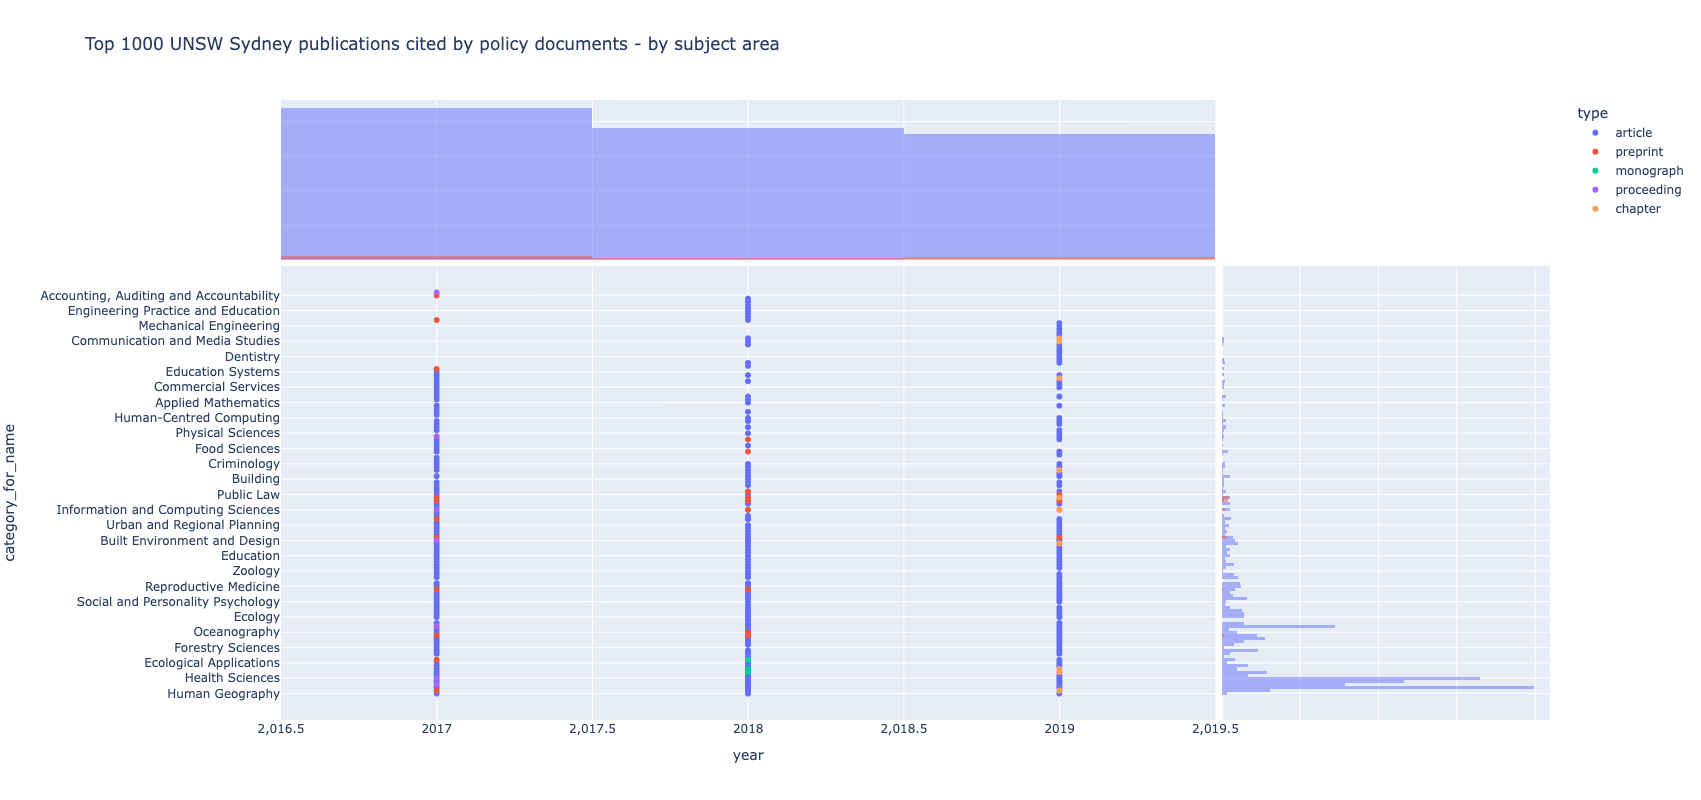

In [16]:
px.scatter(pubs_categories_cited, x="year", y="category_for_name", color="type", 
           hover_name="title", 
           hover_data=["doi", "year", "journal.title"],
           height=800,
           marginal_x="histogram", marginal_y="histogram", 
           title=f"Top {THRESHOLD_PUBS} {ORG} publications cited by policy documents - by subject area")

### Is there a correlation between publication citations and policy document citations? 

Note: if the points on a scatterplot graph produce a lower-left-to-upper-right pattern (see below), this is indicative of a positive correlation between the two variables. This pattern means that when the score of one observation is high, we expect the score of the other observation to be high as well, and vice versa.

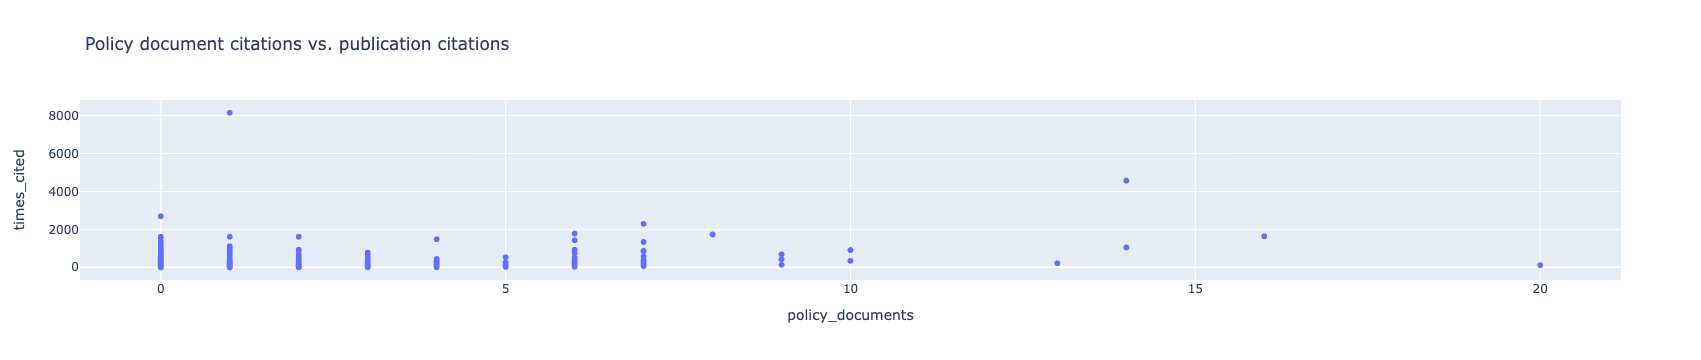

In [17]:
px.scatter(pubs, x="policy_documents", y="times_cited", 
           title=f"Policy document citations vs. publication citations")

---
## Where to go from here

In this [Dimensions Analytics API](https://www.dimensions.ai/dimensions-apis/) tutorial we have seen how, starting from an organization's GRID ID, it is possible to extract a) publications from authors affiliated with this organization, b) policy documents citing those publications (from any publishing organization). 

This only scratches the surface of the possible applications of publications-policy documents linkage data, but hopefully it'll give you a few basic tools to get started building your own application. Here are some ideas for customizing this notebook:

* Change the GRID ID to another one you are more familiar with.
* Use a different way to select publications: for example not using a research organization, but a category, a country, a funder or a combination of the many [publication filters](https://docs.dimensions.ai/dsl/datasource-publications.html) available.